In [1]:
%matplotlib inline
from __future__ import division, absolute_import

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image
from skimage import color 
from skimage.filters.rank import otsu
from skimage.filters import threshold_otsu
from skimage.morphology import diamond
from skimage.morphology import binary_erosion

## Import image Data

In [59]:
# card = Image.open('./FL/G90F121_010F.jpg')
card = Image.open('./FL/G90F121_003F.jpg')
# card = Image.open('./FL/G90F121_018F.jpg')

## First major step is to extract the card from the background

The background is a neutral black with a contrast strip. The stereocards often have a colored background, therefore the easisest method of finding the edges of the card is to use colorspace information. Surveying several cards and several colorspaces, the V channel of YUV colorspace was found to be most reliable

### Convert to the V channel of YUV

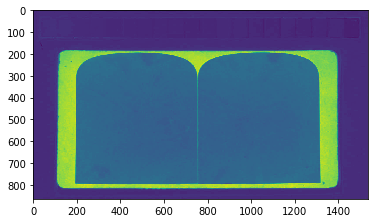

In [60]:
test = color.rgb2yuv(card)[:, :, 2]
plt.imshow(test)
plt.show()

### Find profiles in X and Y directions

In [4]:
def xy_histograms(gray_image):
    """return histogram in x and y directions from gray_image (v from yuv colorspace)"""
    histogram_x = np.squeeze(np.dot(test.T, np.ones((test.shape[0], 1))))
    histogram_y = np.squeeze(np.dot(test, np.ones((test.shape[1], 1))))
    
    return histogram_x, histogram_y


def plot_histograms(gray_image):
    """Show plot of X and Y histograms of image"""
    histogram_x, histogram_y = xy_histograms(gray_image)

    plt.subplot(1, 2, 1)
    plt.plot(histogram_x)
    plt.title('X Values')

    plt.subplot(1, 2, 2)
    plt.plot(histogram_y)
    plt.title('Y Values')

    plt.show()

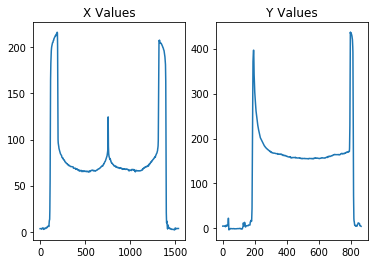

In [61]:
plot_histograms(test)

### Resulting histograms are a bit noisy and can be cleaned up

In [62]:
thresh = threshold_otsu(test)
binary = test > thresh

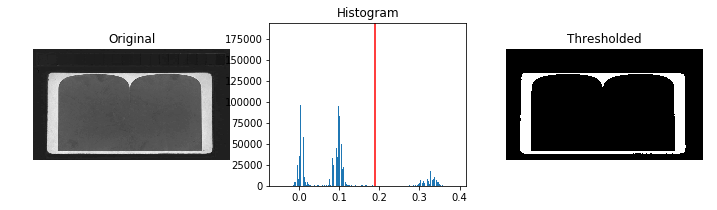

In [63]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 3))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(test, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(test.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

plt.show()

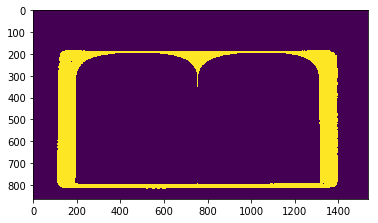

In [64]:
plt.imshow(binary)
plt.show()

### Some morphological cleanup

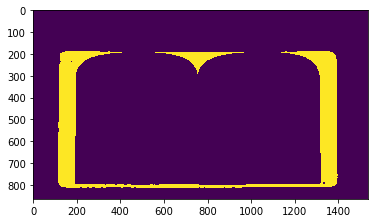

In [65]:
selem = diamond(3)

cleaned = binary_erosion(binary, selem)

plt.imshow(cleaned)
plt.show()

In [49]:
def calculate_bbox(mask, empty_allowed=False):

    histogram_y = np.squeeze(np.dot(mask, np.ones((mask.shape[1], 1))))
    histogram_x = np.squeeze(np.dot(mask.T, np.ones((mask.shape[0], 1))))

    nonzero_y_indexes = np.squeeze(np.where(histogram_y > 0))
    nonzero_x_indexes = np.squeeze(np.where(histogram_x > 0))

    if empty_allowed:
        if not nonzero_y_indexes.size or not nonzero_x_indexes.size:
            # return empty for empty bounding boxes
            return None
        if nonzero_x_indexes.size == 1 or nonzero_y_indexes.size == 1:
            # return empty for single pixel wide bboxes
            return None

    assert len(nonzero_y_indexes) > 0 and len(nonzero_x_indexes) > 0, 'mask should not be empty'

    mask_height, mask_width = mask.shape
    ymin = float(nonzero_y_indexes[0]) / mask_height
    ymax = float(nonzero_y_indexes[-1]) / mask_height
    xmin = float(nonzero_x_indexes[0]) / mask_width
    xmax = float(nonzero_x_indexes[-1]) / mask_width

    # make sure sane bbox values
    assert ymin >= 0.0
    assert ymin < 1.0
    assert ymax >= 0.0
    assert ymax < 1.0
    assert xmin >= 0.0
    assert xmin < 1.0
    assert xmax >= 0.0
    assert xmax < 1.0
    height = ymax - ymin
    assert height >= 0.0
    assert height < 1.0
    width = xmax-xmin
    assert width >= 0.0
    assert width < 1.0
    
    x = xmin * mask_width
    y = ymin * mask_height
    w = (xmax - xmin) * mask_width
    h = (ymax - ymin) * mask_height

    return [x, y, w, h]


def show_bbox(binary_image):
    
    fig, ax = plt.subplots(1)
    ax.imshow(binary_image)
    bbox = calculate_bbox(binary_image)
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3],
                             linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    plt.show()

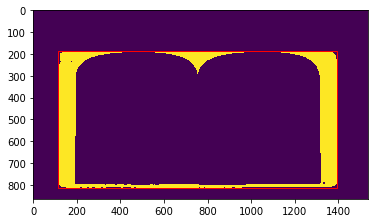

In [66]:
show_bbox(cleaned)

# Gathered as a Library

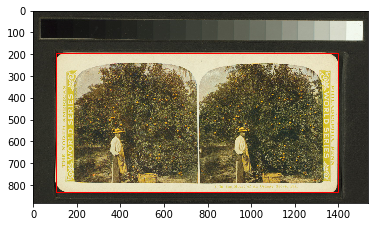

In [8]:
from src.card import card_bbox

card = Image.open('./FL/G90F121_010F.jpg')
bbox = card_bbox(card)

fig, ax = plt.subplots(1)
ax.imshow(card)
rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3],
                             linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

In [2]:
import json

with open('info.json', 'r') as f:
    info = json.load(f)

In [7]:
n = 1
name = info[n]['name']
bbox = info[n]['bbox']

In [8]:
img = Image.open('./FL/{}.jpg'.format(name))

bbox_tuple = (bbox[0],
              bbox[1],
              bbox[0] + bbox[2],
              bbox[1] + bbox[3])

cropped_img = img.crop(box=bbox_tuple)

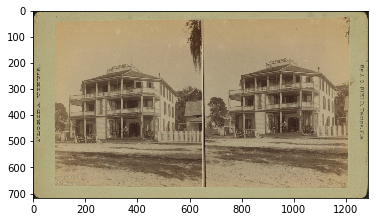

In [9]:
plt.imshow(cropped_img)
plt.show()

### Crop the cards out

In [12]:
for image in info:
    name = image['name']
    bbox = image['bbox']
    
    bbox_tuple = (bbox[0],
              bbox[1],
              bbox[0] + bbox[2],
              bbox[1] + bbox[3])
    img = Image.open('./FL/{}.jpg'.format(name))
    cropped_img = img.crop(box=bbox_tuple)
    
    cropped_img.save('./fl_cards/{}.jpg'.format(name))